In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")
from foundry.util.runtime import setup
setup()
import matplotlib.pyplot as plt
from policy_eval.lower_bounds import stable
from foundry.util.registry import Registry

import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

registry = Registry()

stable.register_datasets(registry)

data = registry.create("lower_bound/stable/1")
env = data.create_env()
train_data, _ = data.split("train").as_pytree()
test_data, _ = data.split("test").as_pytree()
test_x0s = test_data.state[:,0]

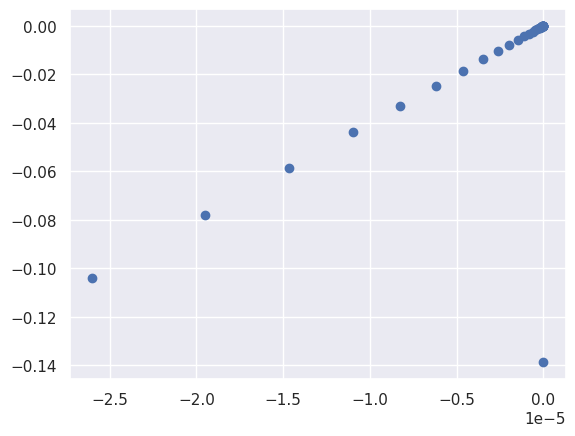

In [2]:
states = train_data.state[4, :, :2]
plt.plot(states[:, 0], states[:, 1], "o")

In [3]:
from foundry.policy import PolicyInput, PolicyOutput
from foundry.core import tree
import foundry.core as F
import foundry.policy
import foundry.numpy as npx

def baseline_policy(x: PolicyInput) -> PolicyOutput:
    action = 0.01*jax.random.normal(x.rng_key, x.state.shape)/npx.sqrt(x.state.shape[0])
    return PolicyOutput(action=action)

def eval(x0):
    rollout = foundry.policy.rollout(env.step, x0, baseline_policy, length=50, policy_rng_key=jax.random.key(42), last_action=True)
    pre_states, actions, post_states = (
        tree.map(lambda x: x[:-1], rollout.states),
        tree.map(lambda x: x[:-1], rollout.actions),
        tree.map(lambda x: x[1:], rollout.states)
    )
    rewards = -F.vmap(env.reward)(
        pre_states, actions, post_states
    )
    return rewards

baseline_rewards = jax.vmap(eval)(test_x0s)

In [4]:
import wandb
import pandas as pd
api = wandb.Api()
sweep = api.sweep("dpfrommer-projects/lower_bound/3tz2pprx")

data = []
method_map = {
    "bc": "Behavior Cloning",
    "diffusion_policy": "Diffusion Policy"
}
for run in sweep.runs:
    if run.state == "finished":
        summary = run.summary
        if run.config["dp.replica_noise"] > 0 and run.config["method"] != "diffusion_policy":
            continue
        else:
            method = method_map[run.config["method"]]
            method = f"{method}{' (Replica)' if run.config['dp.replica_noise'] > 0. else ''}"
        data.append({
            "method": method,
            "replica_noise": run.config["dp.replica_noise"],
            "trajectories": run.config["train_trajectories"],
            "action_length": run.config["action_length"],
            "timesteps": run.config["timesteps"],
            "reward_mean": summary["reward_mean"],
            "reward_std": summary["reward_std"],
            "seed": run.config["seed"],
            "path": "/".join(run.path)
        })
data = pd.DataFrame(data)
# data = data[data.timesteps < 10]
# data = data[data.replica_noise == 0.]
data = data.drop(columns=["path"])
print(data["timesteps"].unique())

[32 26 20 12  8  4  2]


In [5]:
N = len(data["seed"].unique())
data = data.groupby(["method", "replica_noise", "trajectories", "action_length", "timesteps"]).mean().reset_index()
data = data.drop(columns=["seed"])

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot(ax, x, y, yerr=None, **kwargs):
    if "color" not in kwargs:
        color = colors[len(ax.lines)]
    else:
        color = kwargs.pop("color")
    res = ax.plot(x, y, color=color, **kwargs)
    if yerr is not None:
        ax.fill_between(x, y-yerr, y+yerr, color=color, alpha=0.25)
    return res

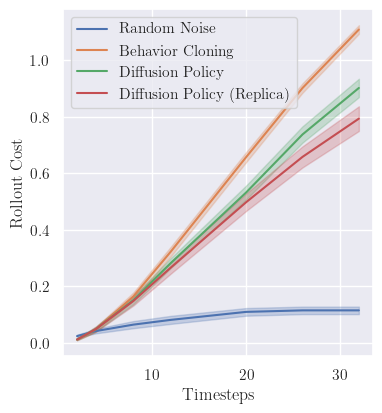

In [7]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Deja Vu Serif"
    # "font.family": "Charter BT Roman"
})

def plot_costs(ax):
    baseline = npx.array([(T, npx.mean(npx.max(baseline_rewards[:, :T], axis=-1)), npx.std(npx.max(baseline_rewards[:, :T], axis=-1))) for T in sorted(data.timesteps.unique())])
    plot(ax,
        baseline[:, 0], baseline[:, 1], yerr=baseline[:,2] / math.sqrt(baseline_rewards.shape[0]), label="Random Noise"
    )

    colors = ["red", "blue", "green"]
    styles = ["-", "--", "-.", ":"]
    method_map = {
        "bc": "BC",
        "diffusion_policy": "Diffusion"
    }
    sub_data = data[(data.trajectories == 4096) & (data.action_length == 1)]
    for (method, method_color) in zip(sub_data.method.unique(), colors):
        method_data = sub_data[sub_data.method == method]
        plot(ax,
            method_data.timesteps, 
            -method_data.reward_mean, 
            yerr=method_data.reward_std / math.sqrt(N*16), # N seeds, 16 runs per seed
            label=f"{method}"
        )
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("Rollout Cost")
    # plt.yscale("log")
    ax.legend()
fig, ax = plt.subplots()
plot_costs(ax)
fig.set_figwidth(4)
fig.set_figheight(4.5)
fig.savefig("timestep_cost.pdf", bbox_inches="tight")
fig.show()

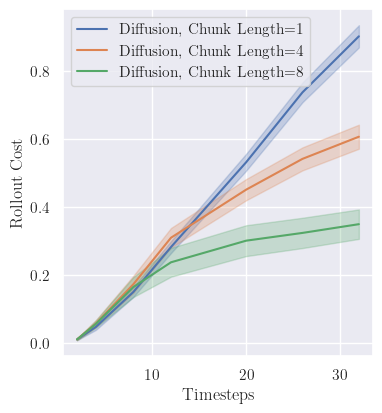

In [8]:
def plot_chunking(ax):
    sub_data = data[(data.trajectories == 4096) & (data.method == "Diffusion Policy") & (data.action_length < 16)]
    # colors = ["red", "blue", "green", "purple", "orange", "brown"]
    for (chunk_length, color) in zip(sub_data.action_length.unique(), colors):
        chunk_data = sub_data[(sub_data.action_length == chunk_length)]
        plot(ax,
            chunk_data.timesteps, 
            -chunk_data.reward_mean, 
            yerr=chunk_data.reward_std / math.sqrt(N * 16),
            label=f"Diffusion, Chunk Length={chunk_length}",
        )
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("Rollout Cost")
    ax.legend(loc="upper left")
fig, ax = plt.subplots()
plot_chunking(ax)
fig.set_figwidth(4)
fig.set_figheight(4.5)
fig.savefig("chunk_lengths.pdf", bbox_inches="tight")
fig.show()

In [9]:
# Lastly, we make a figure showing the blowup for a single timestep...
run = api.run("dpfrommer-projects/policy-eval/voryzti4")
run_history = run.history(keys=["test/loss", "eval/mean_reward", "eval/std_reward"])
run_history

,_step,test/loss,eval/mean_reward,eval/std_reward
0,0,0.182911,-0.067535,0.078991
1,100,0.088682,-0.473836,0.098704
2,200,0.047174,-0.104350,0.072323
3,300,0.025864,-0.180974,0.041124
4,400,0.019668,-0.149440,0.067987
...,...,...,...,...
95,9500,0.000074,-7.250085,1.060403
96,9600,0.000080,-7.157229,1.385835
97,9700,0.000081,-7.061860,1.637702
98,9800,0.000078,-7.339190,0.639505


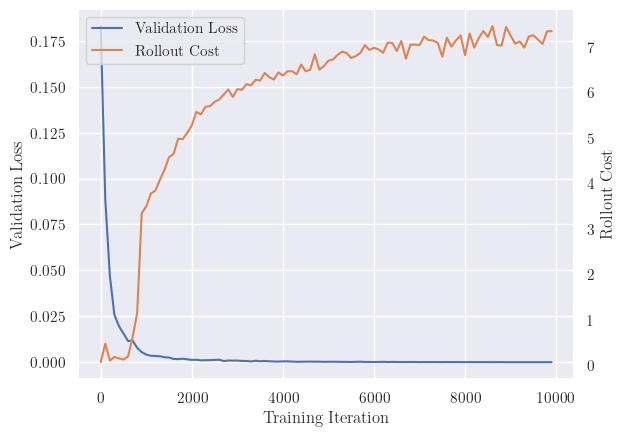

In [12]:
import numpy as np
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

steps = run_history["_step"]

def plot_history(ax1):
    ax2 = ax1.twinx()
    p1, = plot(ax1,
        steps,
        run_history["test/loss"],
        color=colors[0],
        label="Validation Loss"
    )
    p2, = plot(ax2,
        steps,
        -run_history["eval/mean_reward"],
        color=colors[1],
        label="Rollout Cost"
    )
    ax1.tick_params(
        axis="y",
        left=False,
        right=False
    )
    ax2.tick_params(
        axis="y",
        left=False,
        right=False
    )
    ax2.grid(False)
    ax1.set_ylabel("Validation Loss")
    ax2.set_ylabel("Rollout Cost")
    ax1.set_xlabel("Training Iteration")
    ax2.legend(handles=[p1, p2], loc="upper left")
fig, ax = plt.subplots()
plot_history(ax)
fig.savefig("training_curves.pdf", bbox_inches="tight")
fig.show()

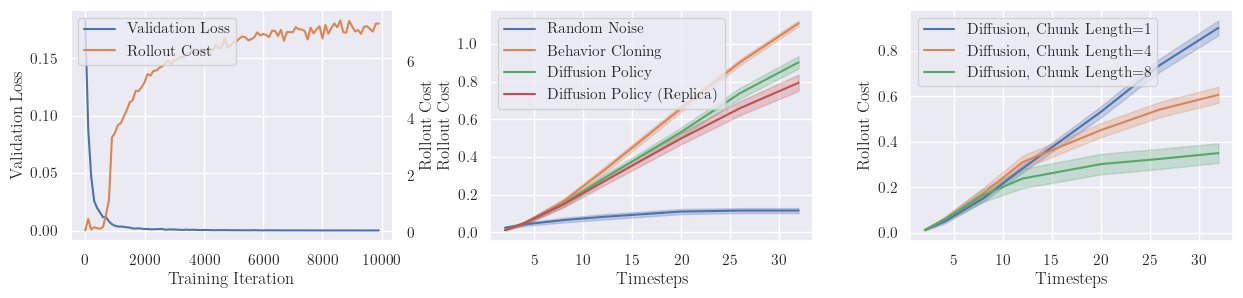

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, )
plot_history(ax1)
plot_costs(ax2)
plot_chunking(ax3)
fig.set_figheight(3)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=0.3)
fig.savefig("combined.pdf", bbox_inches="tight")
fig.show()